In [1]:
from platform import python_version

# En produccion sacar, solo se incluye a modo de informacion
print('Pyton version: {}'.format(python_version()))
import pycaret

from pycaret.nlp import *
from pycaret.datasets import get_data
import pandas as pd
import pprint
import warnings
import spacy

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
%tb
from pycaret.nlp import *

Pyton version: 3.8.10


No traceback available to show.


In [2]:
import pandas as pd
import pprint
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv("IMDB Dataset.csv", error_bad_lines=False)
data = data.sample(5000)

In [20]:
data.head()

,review,sentiment
27921,this is one of michael jackson's best music vi...,1
47048,i guess melville intended this to be the def...,1
13210,this was by far the worst i have ever seen! ...,0
35365,"this is a good , i won't go into any details ...",1
37956,lily powers works at a speakeasy until her fat...,1


In [6]:
#data = data.sample(1000, random_state=786).reset_index(drop=True)

In [7]:
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
data.head()


,review,sentiment
27921,this is one of michael jackson's best music vi...,1
47048,i guess melville intended this to be the def...,1
13210,this was by far the worst i have ever seen! ...,0
35365,"this is a good , i won't go into any details ...",1
37956,lily powers works at a speakeasy until her fat...,1


In [21]:
nlp1=setup(data,target='review')

Description,Value
session_id,3625
Documents,5000
Vocab Size,22477
Custom Stopwords,False


In [22]:
lda = create_model(model='lda', num_topics=3, verbose=True)

In [23]:
lda_results = assign_model(lda)

In [24]:
lda_results.head()

,review,sentiment,Topic_0,Topic_1,Topic_2,Dominant_Topic,Perc_Dominant_Topic
0,NaN,NaN,0.672819,0.307867,0.019314,Topic 0,0.67
1,NaN,NaN,0.356042,0.548300,0.095658,Topic 1,0.55
2,NaN,NaN,0.726783,0.262648,0.010569,Topic 0,0.73
3,NaN,NaN,0.555169,0.425897,0.018934,Topic 0,0.56
4,NaN,NaN,0.395828,0.572230,0.031943,Topic 1,0.57


# gensim

In [30]:
import gensim
from gensim.models import Doc2Vec

In [13]:
df = lda_results.copy()

In [25]:
# Preparing data fro doc2vec training
LabeledSentence = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in data['review'].values:
    all_content_train.append(LabeledSentence(em,[j]))
    j+=1
print('Number of texts processed: ', j)

Number of texts processed:  5000


In [31]:
# Training doc2vec model
d2v_model = Doc2Vec(all_content_train, vector_size = 100, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)


In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

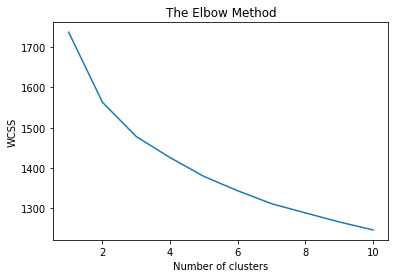

In [34]:
# Determining the number of clusters
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(d2v_model.docvecs.vectors_docs)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [36]:


# Training KMeans model 
kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10,random_state=0) 
X = kmeans_model.fit(d2v_model.docvecs.vectors_docs)



In [38]:
from sklearn.decomposition import PCA

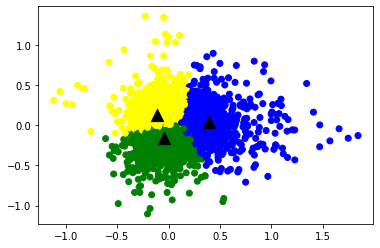

In [39]:
# Plotting the clusters
labels = kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)

plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [43]:
df2 = data.copy()
df2['label'] = kmeans_model.labels_

<AxesSubplot:>

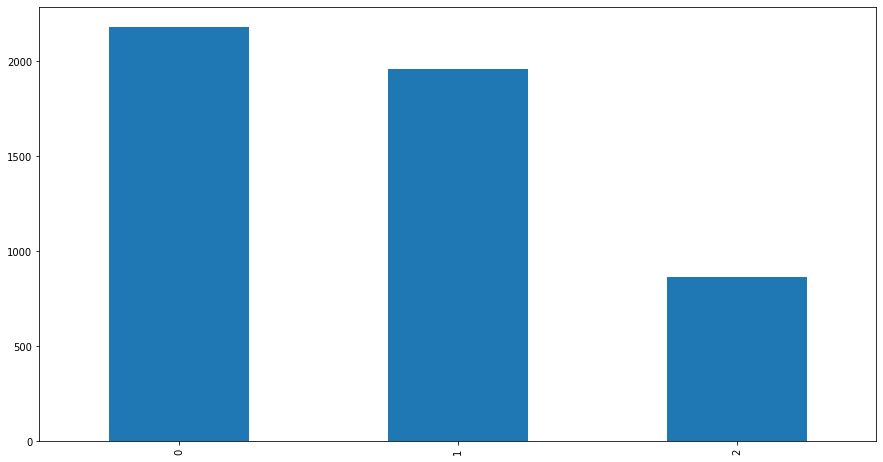

In [44]:
# plotting the distribution
df2['label'].value_counts().plot(kind='bar', figsize=(15,8))

In [47]:
from wordcloud import WordCloud

(2178, 3)


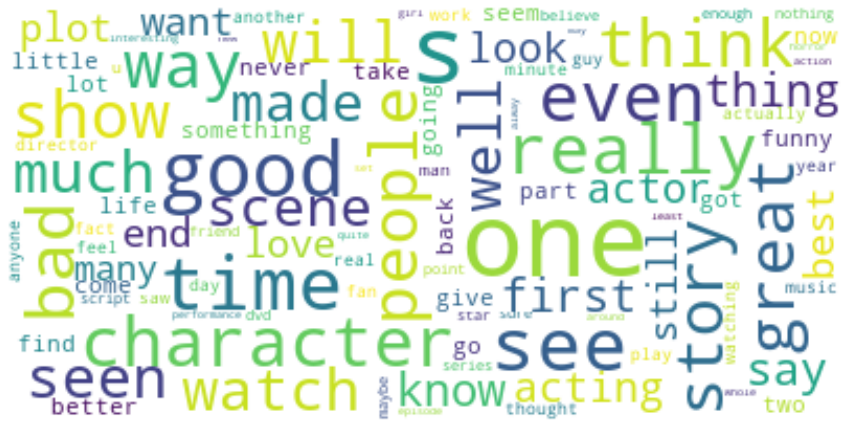

In [48]:
# Plotting one cluster
label = df2[df2['label'] == 0]
print(label.shape)
text = ''
for i in label.index:
    text += ' ' + label['review'][i]

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(863, 3)


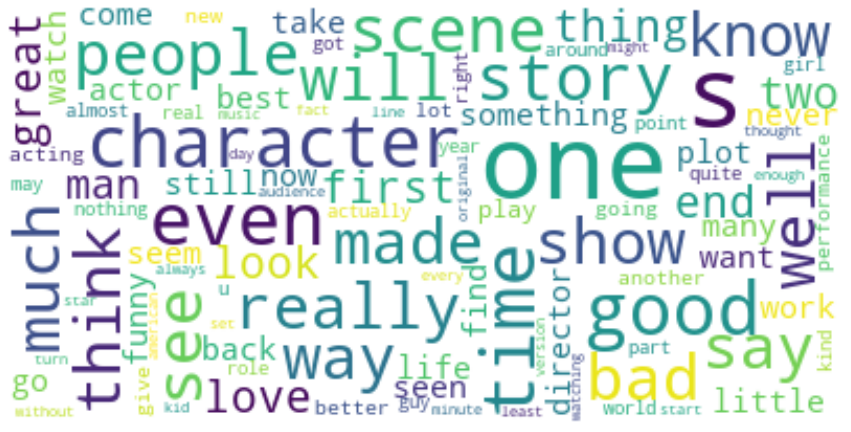

In [49]:
# Plotting one cluster
label = df2[df2['label'] == 2]
print(label.shape)
text = ''
for i in label.index:
    text += ' ' + label['review'][i]

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(1959, 3)


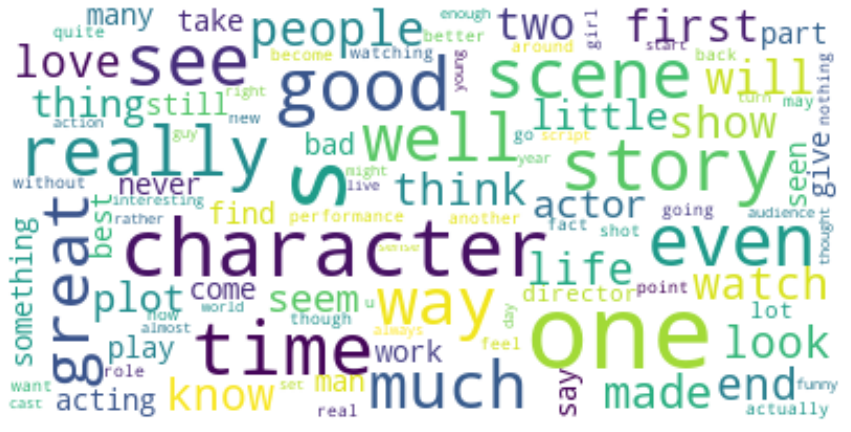

In [50]:
# Plotting one cluster
label = df2[df2['label'] == 1]
print(label.shape)
text = ''
for i in label.index:
    text += ' ' + label['review'][i]

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()